<a href="https://colab.research.google.com/github/firarru/NLP-Spotify-Review/blob/main/NLP_Spotify_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **NABILA ZALFA SHAFIRA**
### **1206220006**

### **Setup**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

### **Loading Data**

In [3]:
url = 'https://raw.githubusercontent.com/firarru/NLP-Spotify-Review/refs/heads/main/Dataset/reviews.csv'
df = pd.read_csv(url, index_col=0)
df

,Review,Rating,Total_thumbsup,Reply
Time_submitted,,,,
2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
...,...,...,...,...
2022-01-01 03:01:29,Even though it was communicated that lyrics fe...,1,6,NaN
2022-01-01 02:13:40,"Use to be sooo good back when I had it, and wh...",1,0,NaN
2022-01-01 01:02:29,This app would be good if not for it taking ov...,2,10,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61594 entries, 2022-07-09 15:00:00 to 2022-01-01 00:19:09
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Review          61594 non-null  object
 1   Rating          61594 non-null  int64 
 2   Total_thumbsup  61594 non-null  int64 
 3   Reply           216 non-null    object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


Terdapat banyak nilai null pada kolom reply, hal tersebut dapat terjadi karena suatu review tidak memiliki balasan komentar dari pihak spotify atau user lain. Sehingga nilai null akan diisi No Reply yang berarti tidak ada balasan komentar

In [5]:
df['Reply'].fillna('No Reply', inplace=True)

In [6]:
df['Rating'].value_counts()

,count
Rating,
5,22095
1,17653
4,7842
2,7118
3,6886


Secara rating, spotify memiliki cukup banyak rating bagus, antara 4 dan 5, yaitu sekitar 29937 rating. Namun rating yang jelek, antara 1 sampai 3, juga lebih banyak yaitu sekitar 31657 rating

In [7]:
df['Total_thumbsup'].value_counts()

,count
Total_thumbsup,
0,42112
1,8360
2,2968
3,1392
4,871
...,...
4550,1
4791,1
713,1


Mengubah kolom rating menjadi data biner

In [8]:
# rating 4, 5 => Positive; 1, 2, 3 => Negative
def ratings(rating):
    if rating > 3 and rating <= 5:
        return "Positive"
    if rating > 0 and rating <= 3:
        return "Negative"

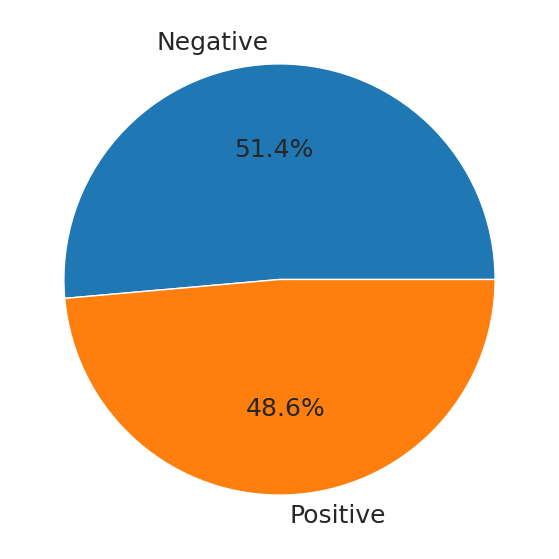

In [9]:
df['Rating_Biner'] = df['Rating'].apply(ratings)
plt.pie(df['Rating_Biner'].value_counts(), labels=df['Rating_Biner'].value_counts().index, autopct='%1.1f%%')
plt.show()

### **EDA**

1. Menghitung karakter dalam setiap review

In [10]:
length = len(df['Review'][0])
print('Panjang karakter dalam Review:', length)

Panjang karakter dalam Review: 112


In [11]:
df['Char_Length'] = df['Review'].str.len()
df.head(5)

,Review,Rating,Total_thumbsup,Reply,Rating_Biner,Char_Length
Time_submitted,,,,,,
2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,No Reply,Positive,112
2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,No Reply,Positive,86
2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,No Reply,Positive,106
2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,No Reply,Negative,47
2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,No Reply,Negative,100


2. Menghitung jumlah kata dalam setiap review

In [12]:
word_count = df['Review'][0].split()
print('Jumlah kata dalam Review:', len(word_count))

Jumlah kata dalam Review: 21


In [13]:
def word_count(review):
  review_list = review.split()
  return len(review_list)

In [14]:
df['Word_Count'] = df['Review'].apply(word_count)
df.head(5)

,Review,Rating,Total_thumbsup,Reply,Rating_Biner,Char_Length,Word_Count
Time_submitted,,,,,,,
2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,No Reply,Positive,112,21
2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,No Reply,Positive,86,15
2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,No Reply,Positive,106,19
2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,No Reply,Negative,47,9
2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,No Reply,Negative,100,21


3. Menghitung average panjang kata

In [15]:
df['Mean Word Length'] = df['Review'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
df.head(5)

,Review,Rating,Total_thumbsup,Reply,Rating_Biner,Char_Length,Word_Count,Mean Word Length
Time_submitted,,,,,,,,
2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,No Reply,Positive,112,21,4.380952
2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,No Reply,Positive,86,15,4.800000
2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,No Reply,Positive,106,19,4.631579
2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,No Reply,Negative,47,9,4.333333
2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,No Reply,Negative,100,21,3.809524


4. Menghitung average panjang kalimat

In [16]:
# nltk.download('punkt_tab')

In [17]:
np.mean([len(sent) for sent in tokenize.sent_tokenize(df['Review'][0])])

55.5

In [18]:
df['Mean Sentence Length'] = df['Review'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))
df.head(5)

,Review,Rating,Total_thumbsup,Reply,Rating_Biner,Char_Length,Word_Count,Mean Word Length,Mean Sentence Length
Time_submitted,,,,,,,,,
2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,No Reply,Positive,112,21,4.380952,55.5
2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,No Reply,Positive,86,15,4.800000,28.0
2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,No Reply,Positive,106,19,4.631579,52.5
2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,No Reply,Negative,47,9,4.333333,47.0
2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,No Reply,Negative,100,21,3.809524,49.5


### **Visualisasi**

In [19]:
def visualize_rating_biner(col):

    print()
    plt.subplot(1,2,1)
    sns.boxplot(y=df[col], hue=df['Rating_Biner'])
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1,2,2)
    sns.kdeplot(data=df, x=col, hue='Rating_Biner', fill=False)
    plt.legend(df['Rating_Biner'].unique())
    plt.xlabel('')
    plt.ylabel('')

    plt.show()

def visualize_rating(col):

    print()
    plt.subplot(1,2,1)
    sns.boxplot(y=df[col], hue=df['Rating'])
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1,2,2)
    sns.kdeplot(data=df, x=col, hue='Rating', fill=False, hue_order=sorted(df['Rating'].unique()))
    plt.legend(df['Rating'].unique())
    plt.xlabel('')
    plt.ylabel('')

    plt.show()

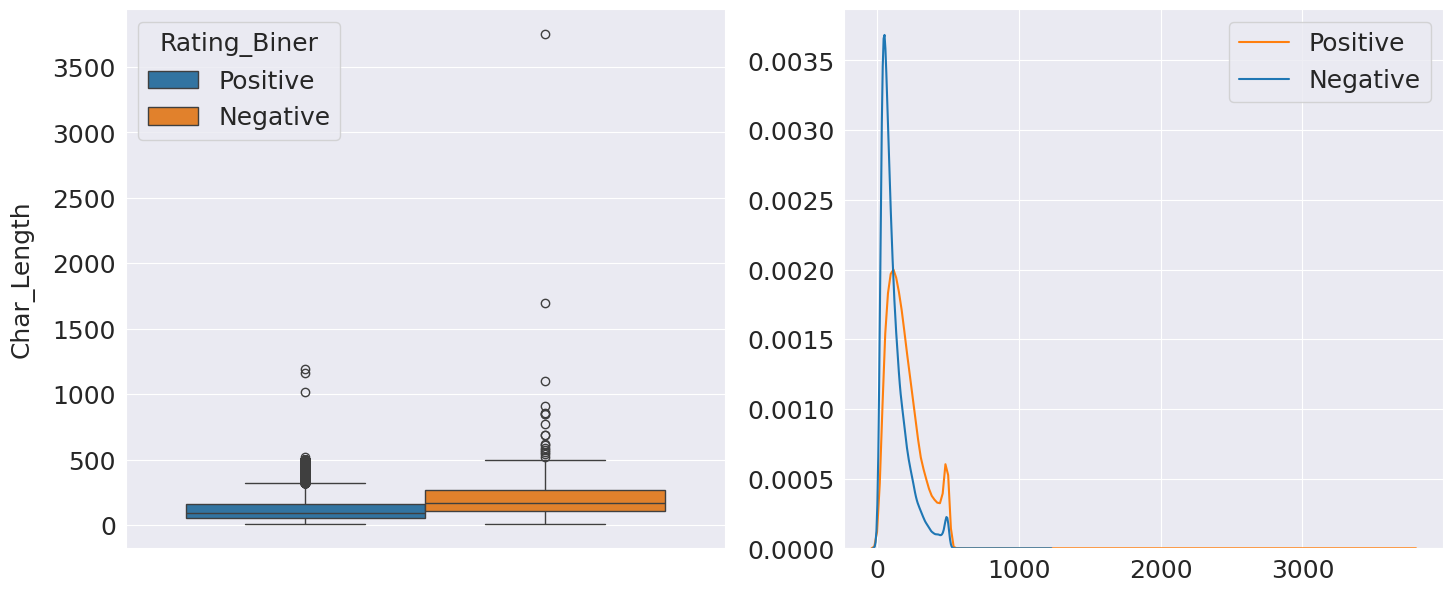

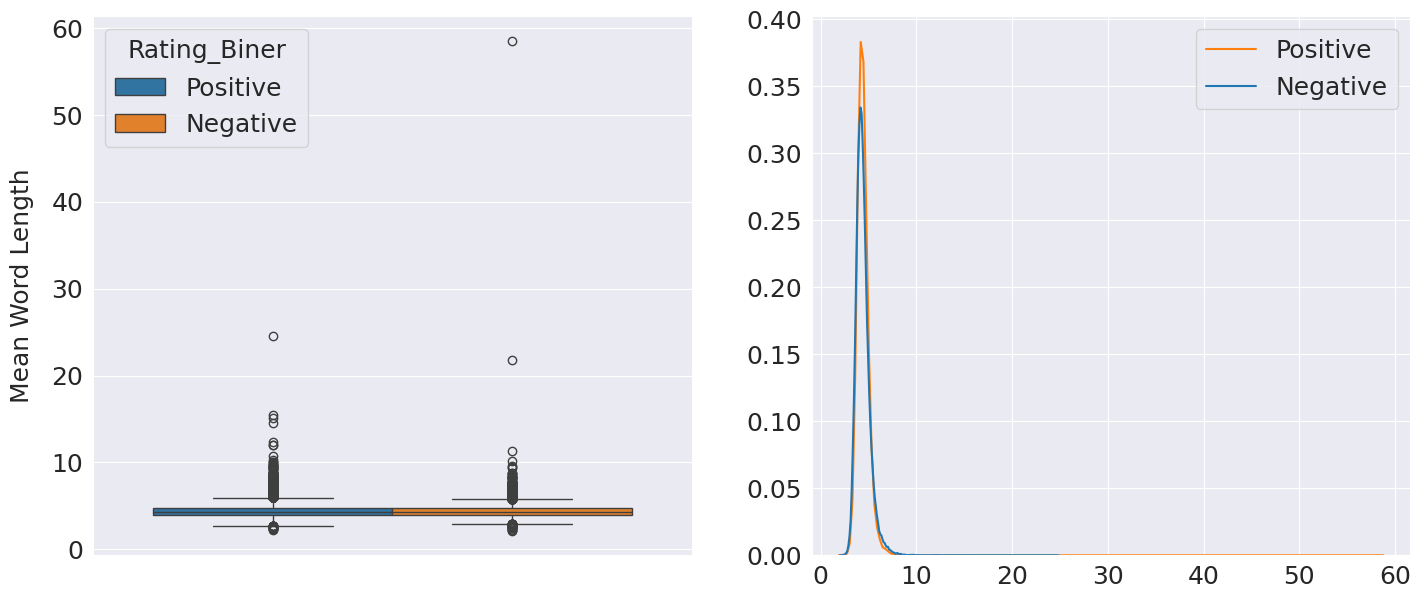

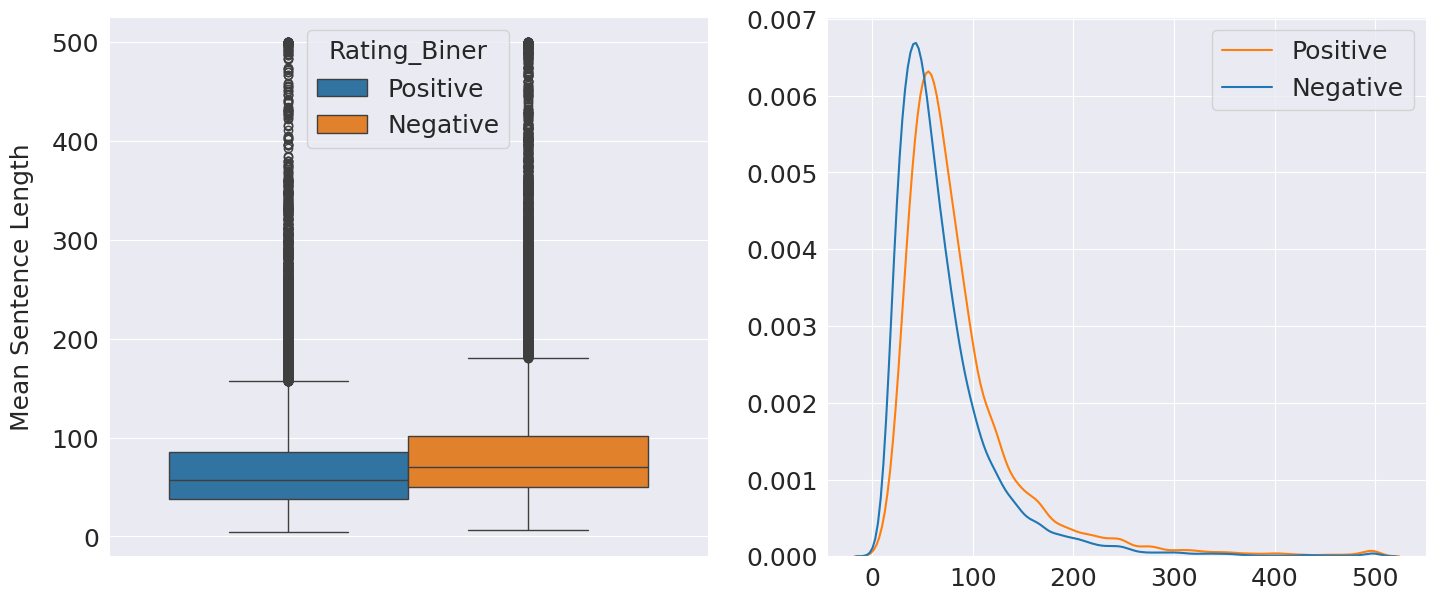

In [20]:
feature = ['Char_Length', 'Mean Word Length', 'Mean Sentence Length']
for col in feature:
    visualize_rating_biner(col)

1.  Char_Length :
Karakter atau huruf pada review negatif cenderung lebih panjang dibandingkan review positif. Hal tersebut mungkin dapat terjadi karena pengguna memberikan review yang panjang berupa kritik atau keluhan mengenai aplikasi


2.  Word_Length :
Jika dihitung berdasarkan kata, antara review positif dan negatif tidak memiliki perbedaan yang signifikan dan cenderung memiliki panjang kata yang sama

3.  Sentence_Length :
Hal yang sama seperti Word_Length juga terjadi pada panjang kalimat review



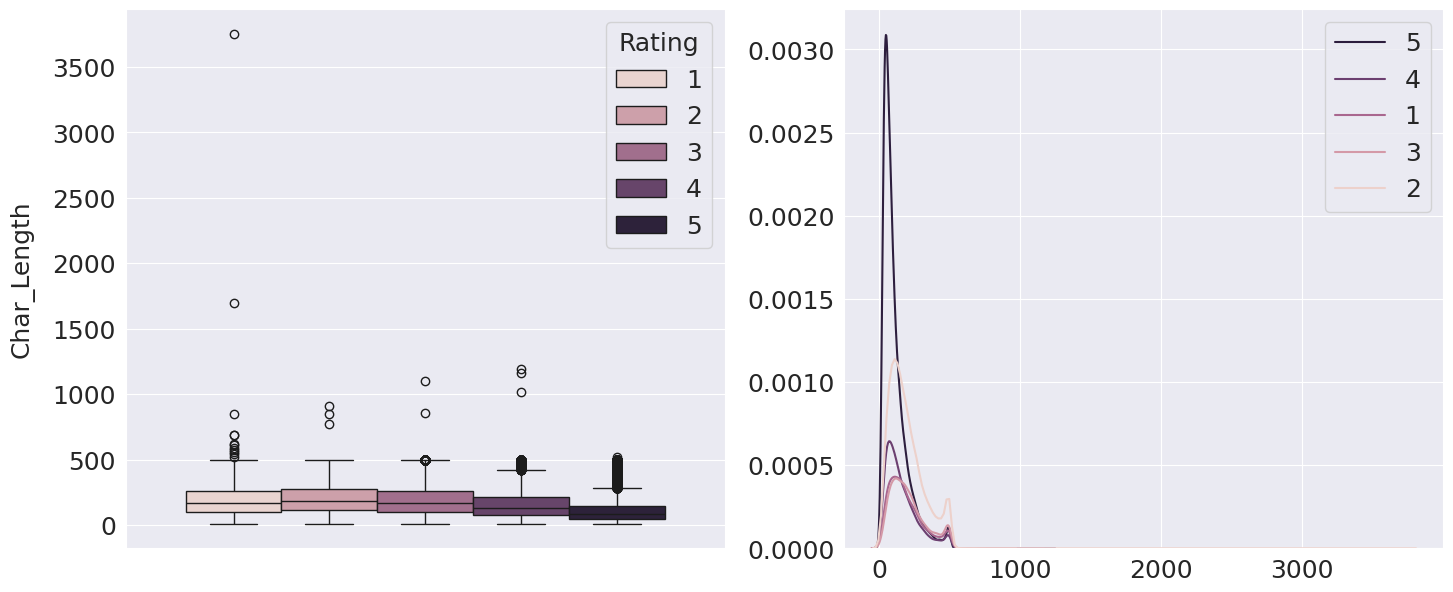

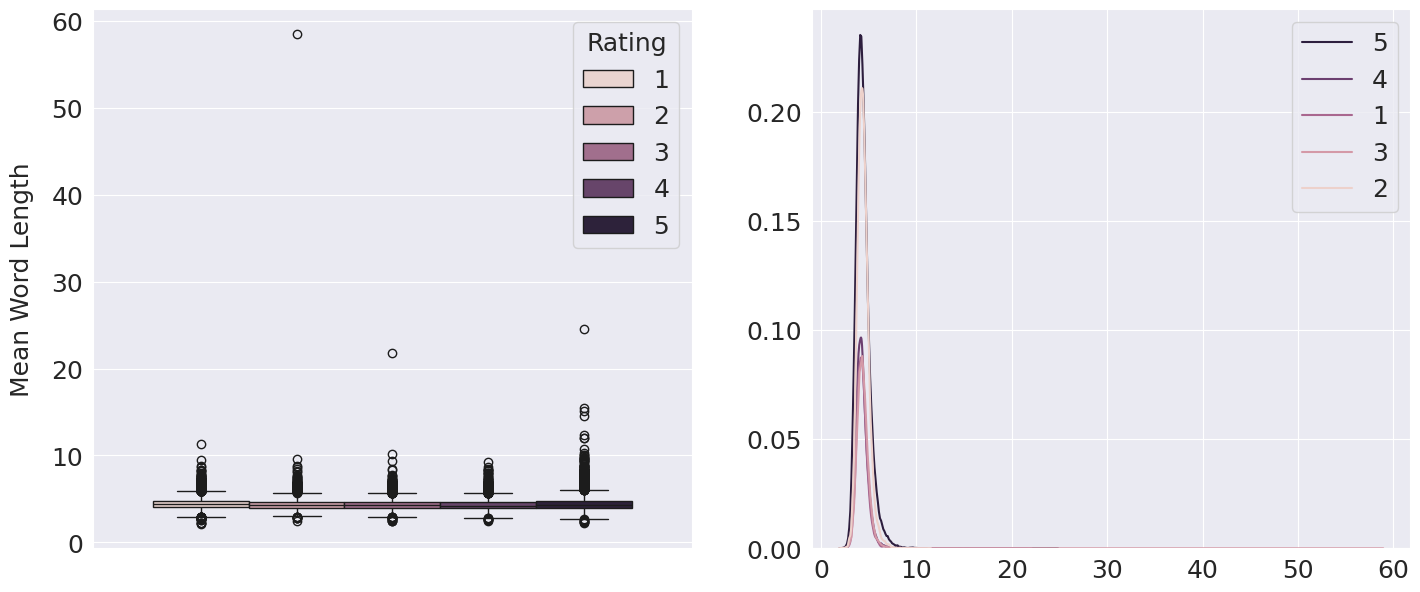

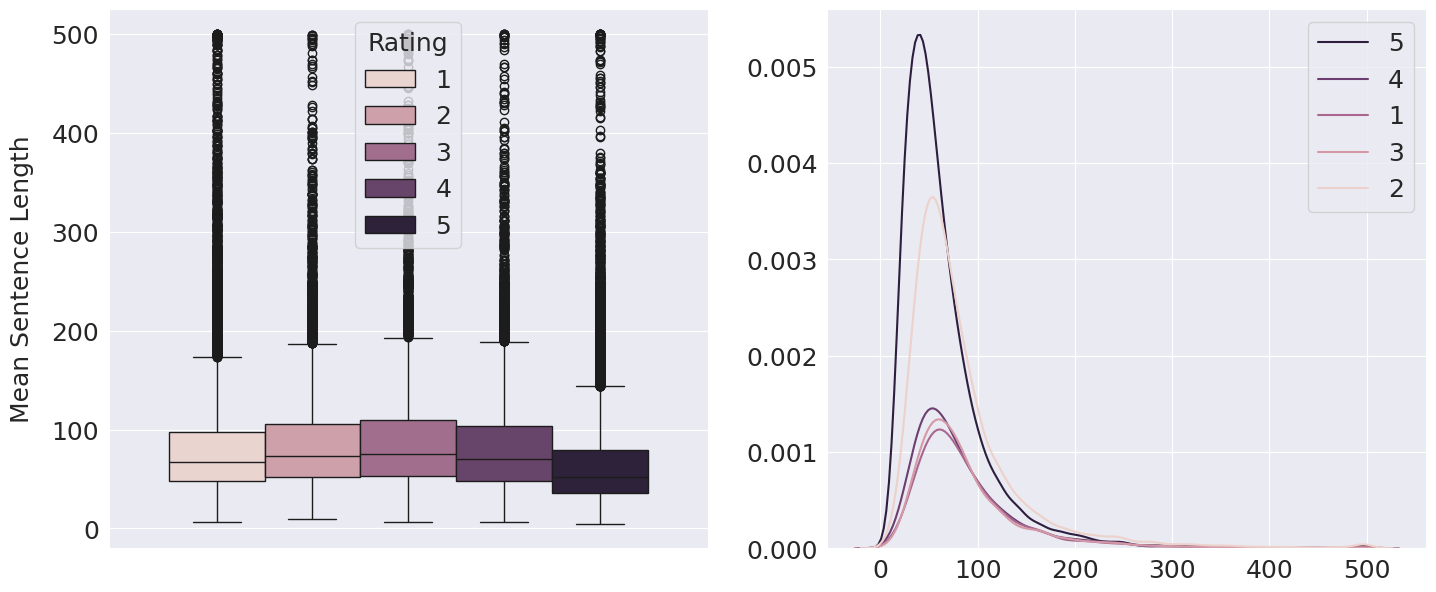

In [21]:
for col in feature:
    visualize_rating(col)

### **Term Frequency Analysis**

In [22]:
df_filter = df[['Review', 'Rating_Biner', 'Word_Count']]
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61594 entries, 2022-07-09 15:00:00 to 2022-01-01 00:19:09
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        61594 non-null  object
 1   Rating_Biner  61594 non-null  object
 2   Word_Count    61594 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.9+ MB


In [23]:
# nltk.download('stopwords')

Karena tidak ada null value, data teks perlu diproses dengan memperhatikan beberapa hal
1. Semua teks diubah menjadi huruf kecil
2. Menghapus tanda baca
3. Menghilangkan stopwords atau kata-kata umum, hal ini perlu disesuaikan dengan bahasa yang digunakan

In [24]:
def clean(review):
  review = review.lower()
  review = re.sub('[^a-z A-Z 0-9-]+', '', review)
  review = " ".join([word for word in review.split() if word not in stopwords.words('english')])
  return review

In [25]:
df_filter['Review'] = df_filter['Review'].apply(clean)
df_filter.head(5)

,Review,Rating_Biner,Word_Count
Time_submitted,,,
2022-07-09 15:00:00,great music service audio high quality app eas...,Positive,21
2022-07-09 14:21:22,please ignore previous negative rating app sup...,Positive,15
2022-07-09 13:27:32,pop-up get best spotify experience android 12 ...,Positive,19
2022-07-09 13:26:45,really buggy terrible use recently,Negative,9
2022-07-09 13:20:49,dear spotify get songs didnt put playlist shuf...,Negative,21


In [26]:
df_filter['Review'][0]

'great music service audio high quality app easy use also quick friendly support'

Kemudian, setiap kata pada setiap review dipisah satu per satu

In [27]:
def corpus(text):
  text_list = text.split()
  return text_list

In [28]:
df_filter['review_list'] = df_filter['Review'].apply(corpus)
df_filter.head(5)

,Review,Rating_Biner,Word_Count,review_list
Time_submitted,,,,
2022-07-09 15:00:00,great music service audio high quality app eas...,Positive,21,"[great, music, service, audio, high, quality, ..."
2022-07-09 14:21:22,please ignore previous negative rating app sup...,Positive,15,"[please, ignore, previous, negative, rating, a..."
2022-07-09 13:27:32,pop-up get best spotify experience android 12 ...,Positive,19,"[pop-up, get, best, spotify, experience, andro..."
2022-07-09 13:26:45,really buggy terrible use recently,Negative,9,"[really, buggy, terrible, use, recently]"
2022-07-09 13:20:49,dear spotify get songs didnt put playlist shuf...,Negative,21,"[dear, spotify, get, songs, didnt, put, playli..."


In [29]:
corpus = []
# for review in df_filter['review_list']:
#   corpus.extend(review)
for i in trange(df_filter.shape[0], ncols=150, nrows=10,
                colour='maroon', smoothing=0.8):
  corpus+=df_filter['review_list'][i]
len(corpus)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 61594/61594 [00:01<00:00, 60442.60it/s]


1011331

In [30]:
mostCommon = Counter(corpus).most_common(15)
mostCommon

[('app', 35591),
 ('music', 25433),
 ('spotify', 18771),
 ('songs', 18217),
 ('song', 14672),
 ('play', 11308),
 ('like', 9760),
 ('listen', 9325),
 ('cant', 9103),
 ('love', 8975),
 ('premium', 8921),
 ('good', 8720),
 ('ads', 8496),
 ('great', 7299),
 ('dont', 7146)]

In [31]:
words = []
freq = []
for word, count in mostCommon:
  words.append(word)
  freq.append(count)

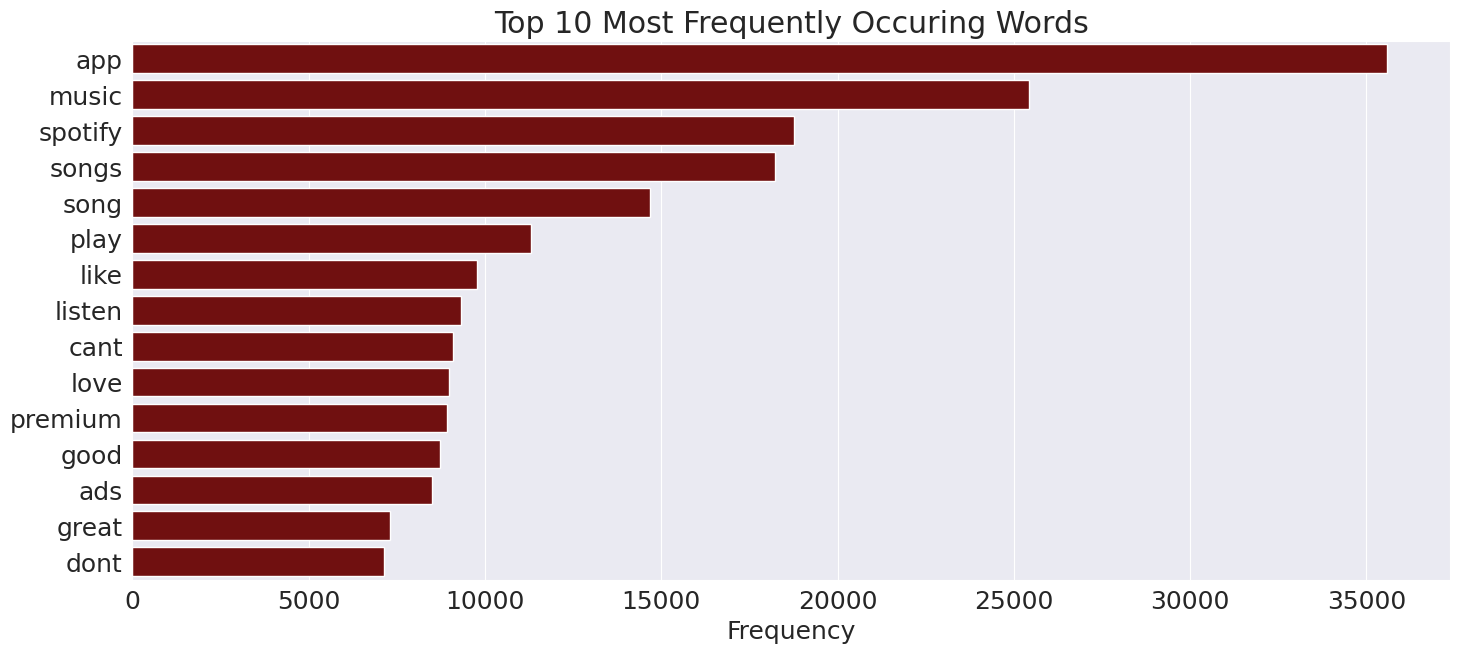

In [32]:
sns.barplot(x=freq, y=words, color='maroon')
plt.xlabel('Frequency')
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

### **Most Frequently Memakai N-grams**

In [50]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df_filter['Review'])

In [51]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

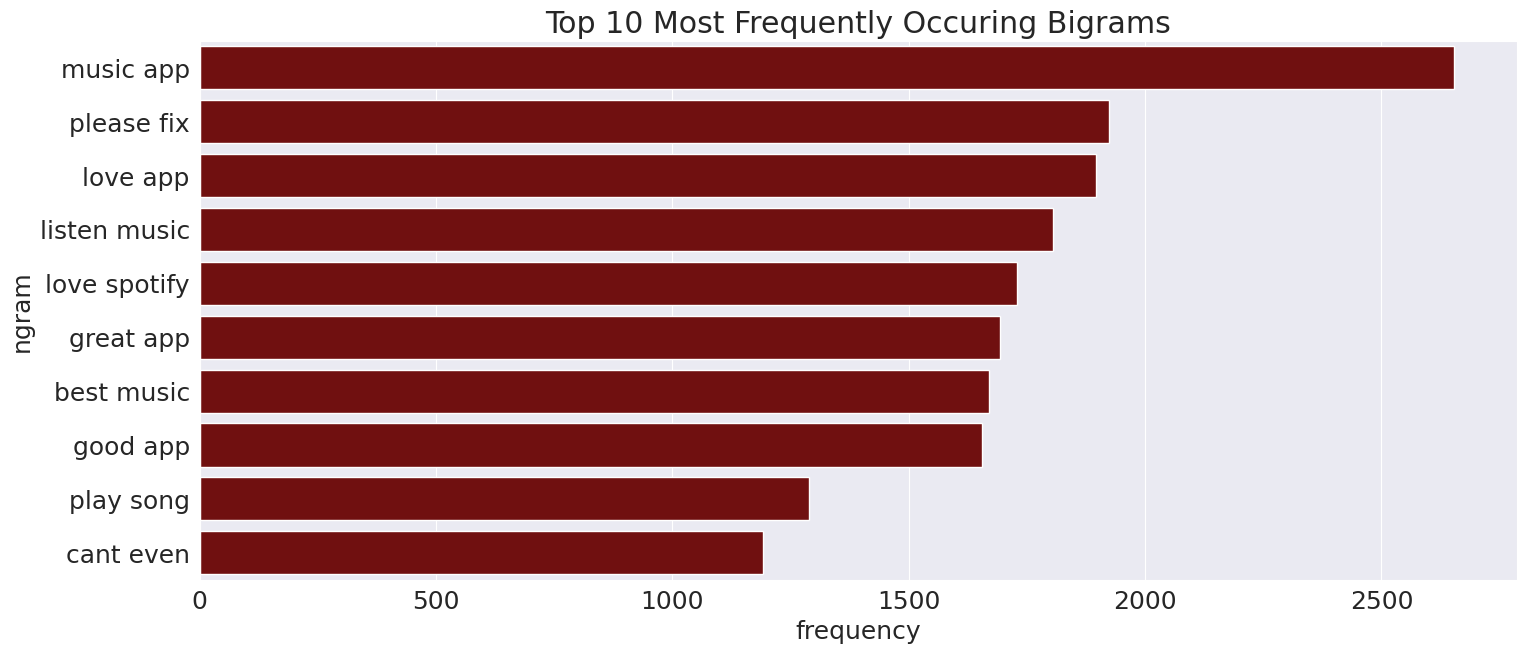

In [52]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], color='maroon')
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

### **WORDCLOUD**

In [53]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import requests

In [54]:
comment_words=''
stopwords = set(STOPWORDS)

In [55]:
for val in ngram_freq.ngram:
    val = str(val)
    tokens = val.split()
    for i in range (len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens) + " "

In [56]:
pic = np.array(Image.open(requests.get('https://www.clker.com/cliparts/I/R/2/x/b/F/easter-bunny-with-eggs-md.png', stream=True).raw))
WordCloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords, mask=pic,
                      min_font_size=10).generate(comment_words)

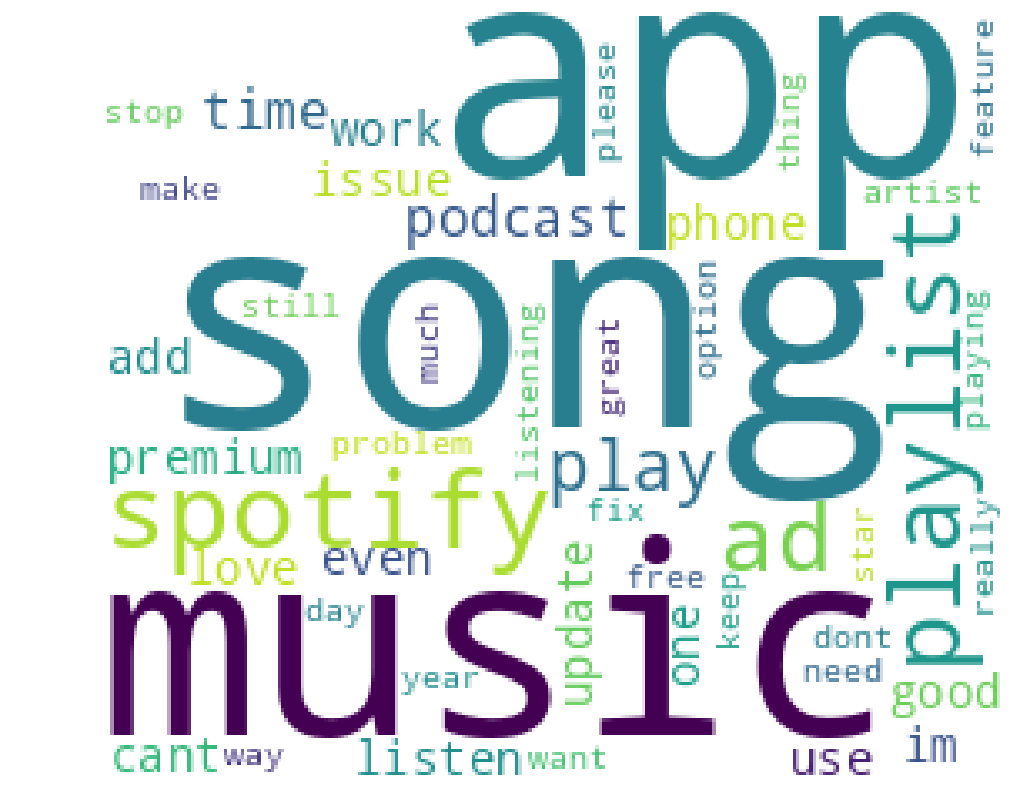

In [57]:
plt.figure(figsize=(10,10), facecolor='white', edgecolor='green')
plt.imshow(WordCloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()